<a href="https://colab.research.google.com/github/Mani3443/house_price_prediction/blob/main/HOUSEPRICE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q xgboost scikit-learn pandas matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib

# For reproducibility
RANDOM_STATE = 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
DATA_DIR = "/content/drive/My Drive"  # No subfolder
train_csv = os.path.join(DATA_DIR, "train.csv")

import pandas as pd
df = pd.read_csv(train_csv)
print("Shape:", df.shape)
df.head()

Mounted at /content/drive
Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Load dataset
df = pd.read_csv(train_csv)
df.shape, df.columns[:20]

((1460, 81),
 Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
        'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt'],
       dtype='object'))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Rows,Cols: (1460, 81)
Missing values per column (top 20):


,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


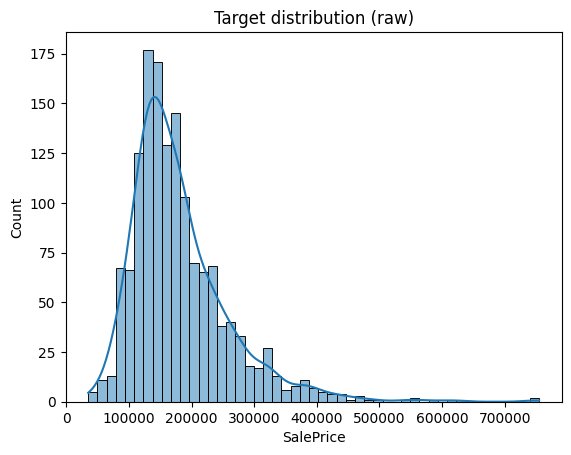

Skew: 1.8828757597682129


In [ ]:
# Quick look
display(df.head())
print("Rows,Cols:", df.shape)
print("Missing values per column (top 20):")
display(df.isnull().sum().sort_values(ascending=False).head(20))

# Target distribution (assume target column 'SalePrice' — change if different)
target = 'SalePrice'
if target in df.columns:
    sns.histplot(df[target], kde=True)
    plt.title("Target distribution (raw)")
    plt.show()

    # skewness
    print("Skew:", df[target].skew())
else:
    print(f"Target column '{target}' not found. Check your CSV.")

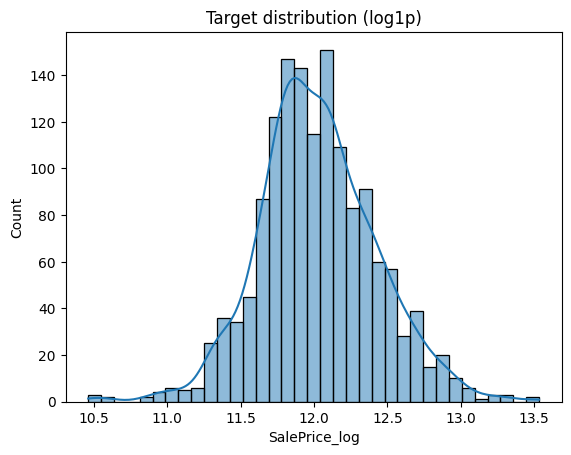

In [ ]:
# If SalePrice is skewed (common), apply log transform for modeling
if 'SalePrice' in df.columns:
    df['SalePrice_log'] = np.log1p(df['SalePrice'])
    sns.histplot(df['SalePrice_log'], kde=True)
    plt.title("Target distribution (log1p)")
    plt.show()
else:
    print("No SalePrice column found — adapt code to your dataset.")

In [ ]:
# Start with a simple feature set to demonstrate pipeline.
# We'll pick some numeric and categorical columns commonly in house datasets.
# Modify these lists to match your CSV's column names.

numeric_features = ['LotArea','OverallQual','OverallCond','YearBuilt','1stFlrSF','2ndFlrSF','GrLivArea','FullBath','HalfBath','TotRmsAbvGrd']
categorical_features = ['Neighborhood','MSZoning','Street','CentralAir']

# Keep only those that exist in your df
numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = [c for c in categorical_features if c in df.columns]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd']
Categorical: ['Neighborhood', 'MSZoning', 'Street', 'CentralAir']


In [ ]:
# Use the log target for modeling if available
y = df['SalePrice_log'] if 'SalePrice_log' in df.columns else df['SalePrice']
X = df[numeric_features + categorical_features]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape)


Train shape: (1168, 14) Valid shape: (292, 14)


In [ ]:
# Numeric pipeline: impute (median) + scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute (most frequent) + one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [ ]:
# Baseline: predict mean
y_mean = np.mean(y_train)
baseline_pred = np.full(len(y_valid), y_mean)

# Manually compute RMSE for baseline
mse_baseline = mean_squared_error(y_valid, baseline_pred)
rmse_baseline = np.sqrt(mse_baseline)
print("Baseline RMSE (log target):", rmse_baseline)

# Linear regression pipeline
lin_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit and predict
lin_pipe.fit(X_train, y_train)
pred_lin = lin_pipe.predict(X_valid)

# Manually compute RMSE for linear regression
mse_linear = mean_squared_error(y_valid, pred_lin)
rmse_linear = np.sqrt(mse_linear)
print("Linear RMSE (log target):", rmse_linear)


Baseline RMSE (log target): 0.43324391618066094
Linear RMSE (log target): 0.14446757222913556


In [ ]:
# Random Forest pipeline
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
])
rf_pipe.fit(X_train, y_train)
pred_rf = rf_pipe.predict(X_valid)

# Manually compute RMSE for Random Forest
mse_rf = mean_squared_error(y_valid, pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("RandomForest RMSE (log target):", rmse_rf)

# XGBoost pipeline (use sklearn API wrapper)
xgb_model = xgb.XGBRegressor(n_estimators=200, random_state=RANDOM_STATE, verbosity=0)
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])
xgb_pipe.fit(X_train, y_train)
pred_xgb = xgb_pipe.predict(X_valid)

# Manually compute RMSE for XGBoost
mse_xgb = mean_squared_error(y_valid, pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost RMSE (log target):", rmse_xgb)


RandomForest RMSE (log target): 0.14712554669347583
XGBoost RMSE (log target): 0.15144421892922372


In [ ]:
def cv_rmse(pipe, X, y, cv=5):
    # cross_val_score returns neg MSE if scoring='neg_mean_squared_error'
    scores = cross_val_score(pipe, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores

print("Linear CV RMSE:", cv_rmse(lin_pipe, X, y))
print("RF CV RMSE:", cv_rmse(rf_pipe, X, y))
print("XGB CV RMSE:", cv_rmse(xgb_pipe, X, y))

Linear CV RMSE: [0.13341237 0.15899362 0.15292015 0.13434292 0.18391471]
RF CV RMSE: [0.14389288 0.16179333 0.15434438 0.13489316 0.15682054]
XGB CV RMSE: [0.13961796 0.16276173 0.15225898 0.13806701 0.14794178]


In [ ]:
# Example param grid for XGBoost
param_dist = {
    'regressor__n_estimators': [100, 200, 400],
    'regressor__max_depth': [3, 5, 8],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}

rs = RandomizedSearchCV(xgb_pipe, param_distributions=param_dist, n_iter=12,
                        scoring='neg_mean_squared_error', cv=3,
                        random_state=RANDOM_STATE, n_jobs=-1, verbose=1)

rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
best_model = rs.best_estimator_

# Evaluate on validation
pred_best = best_model.predict(X_valid)
mse_best = mean_squared_error(y_valid, pred_best)
rmse_best = np.sqrt(mse_best)
print("Tuned XGB RMSE (log target):", rmse_best)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'regressor__subsample': 1.0, 'regressor__n_estimators': 200, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.05, 'regressor__colsample_bytree': 0.8}
Tuned XGB RMSE (log target): 0.137031446670769


In [ ]:
# If your target was log-transformed, convert predictions back:
def inv_log(x):
    return np.expm1(x)  # inverse of log1p

# Convert predictions and true values back to original scale
y_valid_pred_log = best_model.predict(X_valid)
y_valid_pred = inv_log(y_valid_pred_log)
y_valid_true = inv_log(y_valid) if 'SalePrice_log' in df.columns else y_valid

# Manually compute RMSE and MAE
mse_final = mean_squared_error(y_valid_true, y_valid_pred)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_valid_true, y_valid_pred)

print("Final RMSE (original scale):", rmse_final)
print("Final MAE (original scale):", mae_final)


Final RMSE (original scale): 29151.89122703074
Final MAE (original scale): 18222.25282266696


,0
OverallQual,0.344511
GrLivArea,0.096617
CentralAir_N,0.091395
MSZoning_RM,0.066878
CentralAir_Y,0.065110
YearBuilt,0.049259
Neighborhood_OldTown,0.041597
FullBath,0.040532
1stFlrSF,0.035267
LotArea,0.020491


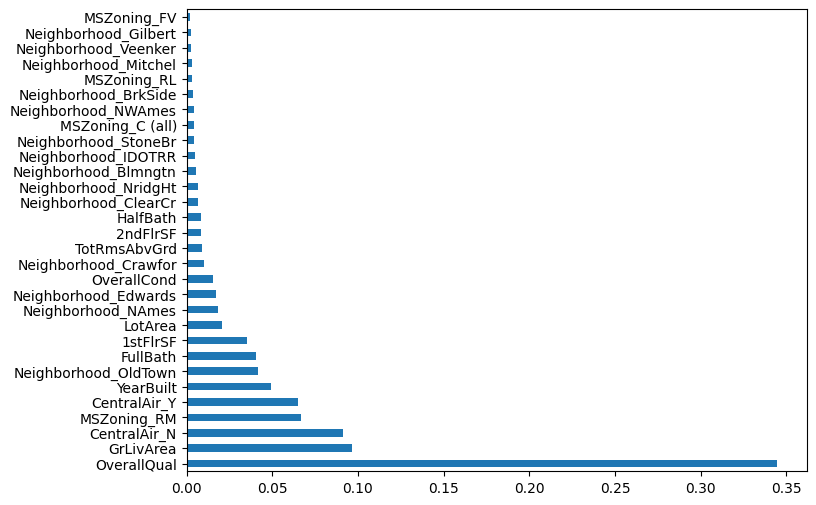

In [ ]:
# To show feature importances, we need the preprocessed feature names:
preprocessor_fit = preprocessor.fit(X_train)
num_cols = numeric_features
cat_cols = list(preprocessor_fit.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
feature_names = num_cols + cat_cols

# If using RandomForest / XGBoost:
reg = best_model.named_steps['regressor']
importances = reg.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
display(feat_imp)
feat_imp.plot(kind='barh', figsize=(8,6))
plt.show()

In [ ]:
# Save the entire pipeline (preprocessor + model)
output_path = os.path.join(DATA_DIR, "house_price_pipeline.joblib")
joblib.dump(best_model, output_path)
print("Saved pipeline to:", output_path)

Saved pipeline to: /content/drive/My Drive/house_price_pipeline.joblib


In [ ]:
y_pred_log = best_model.predict(X_valid)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_valid) if 'SalePrice_log' in df.columns else y_valid

result_df = pd.DataFrame({
    'Actual Price': y_true.values,
    'Predicted Price': y_pred
})
display(result_df.head(10))

,Actual Price,Predicted Price
0,154500.0,146847.500000
1,325000.0,349941.437500
2,115000.0,115493.992188
3,159000.0,146776.937500
4,315500.0,288006.187500
5,75500.0,85230.265625
6,311500.0,243431.171875
7,146000.0,142729.078125
8,84500.0,85230.265625
9,135500.0,142634.500000


In [ ]:
# Manually compute RMSE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# MAE is safe to use directly
mae = mean_absolute_error(y_true, y_pred)

# Print results
print(f"✅ RMSE: {rmse:,.2f}")
print(f"✅ MAE:  {mae:,.2f}")

✅ RMSE: 29,151.89
✅ MAE:  18,222.25


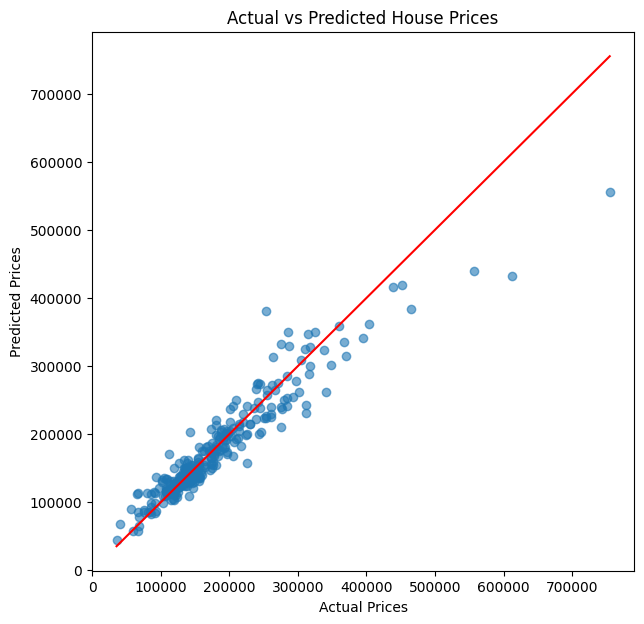

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red')
plt.show()

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2:.3f}")

R² Score: 0.889
